In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re
from IPython.display import display 
from csv import QUOTE_NONE 

In [2]:
SAM_COL_NAMES = ['QNAME', 'FLAG', 'RNAME', 'POS', 'MAPQ', 'CIGAR', 'RNEXT', 'PNEXT', 'TLEN', 'SEQ', 'QUAL', 'TAGS']

In [3]:
def read_data(ref_path, sam_path, skiprows=2):
    ref = ''
    with open(ref_path, 'r') as fi:
        for line in fi:
            if line[0] != '>':
                ref += line.strip()
    ref_len = len(ref)
    
    sam = pd.read_csv(sam_path, sep='\t', skiprows=skiprows, quoting=QUOTE_NONE, names=SAM_COL_NAMES)
    sam['seq_len'] = sam['SEQ'].apply(len)
    return ref, ref_len, sam

In [4]:
def qual(c, quality_offset=33):
    return ord(c) - quality_offset

In [5]:
def stats(L):
    if isinstance(L, np.ndarray):
        A = L
    else:
        A = np.array(L)
        
    if len(A) == 0:
        print('(пусто)')
        return

    _mean = np.mean(A)
    _std = np.std(A)
    print(f'Среднее {_mean:.1f}')
    print(f'Среднеквадратичное отклонение {_std:.1f}')
    print(f'Минимум {np.min(A)}, максимум {np.max(A)}')
    print(f'Интервал, в который попадает 95% [{_mean - 2*_std:.1f}, {_mean + 2*_std:.1f}]')

In [6]:
def coverage(sam, ref_len):
    cover = np.zeros(ref_len)
    for i in sam.index:
        if sam.loc[i, 'POS'] > 0:
            for j in range(sam.loc[i, 'POS'], sam.loc[i, 'POS'] + sam.loc[i, 'seq_len']):
                if j < ref_len:
                    cover[j-1] += 1
    cover_1000 = [np.mean(cover[i:i+1000]) for i in range(0, ref_len, 1000)]
    
    plt.plot(cover_1000)
    plt.grid(alpha=0.75)
    plt.xlabel('Reference position (thousands of nucleotides)')
    plt.ylabel('Number of reads')
    plt.title('Coverage')
    plt.show()
    
    print(f'Среднее покрытие: {np.mean(cover):.1f}')
    print(f'Доля покрытой области генома {sum(cover > 0)/ref_len*100:.1f}%')

In [28]:
def errors(sam, ref):
    errors_count = defaultdict(Counter)
    indels = []
    qual_mismatch = []
    qual_insert = []
    indels_n = 0
    indels_poly = 0
    
    for n in sam.index:
        pos = sam.loc[n, 'POS']
        if pos == 0 or sam.loc[n, 'CIGAR'] == '*' or sam.loc[n, 'SEQ'] == '*':
            continue
        
        read_seq = sam.loc[n, 'SEQ']
        read_qual = sam.loc[n, 'QUAL']
        cigar = re.findall(r'(\d+)([MIDNSHP=X])', sam.loc[n, 'CIGAR'])
        seq_aligned = ''
        
        i = 0
        j = 0
        for cig_len, cig_ch in cigar:
            if cig_ch in 'DI':
                indels.append(int(cig_len))
                
            for _ in range(int(cig_len)):
                if cig_ch == 'M':
                    # match or mismatch
                    seq_aligned += read_seq[i]
                    ref_nuc = ref[pos + j - 1]
                    read_nuc = read_seq[i]
                    if ref_nuc != read_nuc:
                        qual_mismatch.append(qual(read_qual[i]))
                elif cig_ch == 'D':
                    # deletion
                    seq_aligned += '_'
                    ref_nuc = ref[pos + j - 1]
                    read_nuc = '_'
                elif cig_ch == 'I':
                    # insertion
                    seq_aligned += '_'
                    ref_nuc = '_'
                    read_nuc = read_seq[i]
                    qual_insert.append(qual(read_qual[i]))
                
                if cig_ch in 'MDI':
                    errors_count[ref_nuc][read_nuc] += 1

                if cig_ch not in 'DNHP':
                    i += 1
                if cig_ch not in 'ISHP':
                    j += 1                
        
        poly_spans = [s.span() for s in re.finditer(r'([ATGC])\1{4,}', seq_aligned)]
        for i, c in enumerate(seq_aligned):
            if c != '_':
                continue
            indels_n += 1
            for a, b in poly_spans:
                if i == b + 1 or i == a - 1:
                    indels_poly += 1
                    break
            
    errors_df = pd.DataFrame(errors_count).fillna(0)
    
    display(errors_df.div(errors_df.sum(axis=1), axis=0))
    
    total = errors_df.sum().sum()
    true = sum([errors_count[i][i] for i in errors_count])
    print(f'\nСредний процент ошибок в ридах {(total-true)/total*100:.4f}%')
    
    print('\nСтатистика длин инделов')
    stats(indels)
    
    print('\nСтатистика качества (замена)')
    stats(qual_mismatch)
    
    print('\nСтатистика качества (вставка)')
    stats(qual_insert)
    
    if indels_n != 0:
        print(f'\nПроцент инделов, находящихся рядом с гомополимерными участками {indels_poly/indels_n*100:.1f}%')
    

# PacBio

In [8]:
!samtools flagstat pacbio_40x.sam

52081 + 0 in total (QC-passed reads + QC-failed reads)
1736 + 0 secondary
8898 + 0 supplementary
0 + 0 duplicates
51199 + 0 mapped (98.31% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [18]:
ref, ref_len, sam = read_data('reference.fasta', 'pacbio_40x.sam')

## 1. Покрытие генома

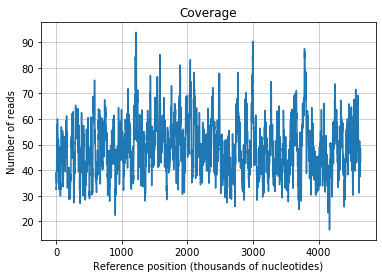

Среднее покрытие: 48.7
Доля покрытой области генома 100.0%


In [19]:
coverage(sam, ref_len)

## 2. Частоты различных замен

In [29]:
errors(sam, ref)

,C,T,G,A,_
C,0.884250,0.006296,0.008486,0.007216,0.093752
G,0.008480,0.007346,0.883828,0.006273,0.094073
_,0.295477,0.204810,0.294469,0.205245,0.000000
A,0.009525,0.005943,0.006718,0.896472,0.081341
T,0.006732,0.896677,0.009381,0.005953,0.081257



Средний процент ошибок в ридах 14.0762%

Статистика длин инделов
Среднее 1.4
Среднеквадратичное отклонение 3.3
Минимум 1, максимум 2798
Интервал, в который попадает 95% [-5.1, 8.0]

Статистика качества (замена)
Среднее 6.6
Среднеквадратичное отклонение 4.5
Минимум 0, максимум 15
Интервал, в который попадает 95% [-2.4, 15.6]

Статистика качества (вставка)
Среднее 6.8
Среднеквадратичное отклонение 4.4
Минимум 0, максимум 15
Интервал, в который попадает 95% [-2.1, 15.6]

Процент инделов, находящихся рядом с гомополимерными участками 0.9%


# Oxford Nanopores

In [30]:
!samtools flagstat ONT_2D.sam

32103 + 0 in total (QC-passed reads + QC-failed reads)
1072 + 0 secondary
221 + 0 supplementary
0 + 0 duplicates
29565 + 0 mapped (92.09% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [31]:
ref, ref_len, sam = read_data('reference.fasta', 'ONT_2D.sam')

## 1. Покрытие генома

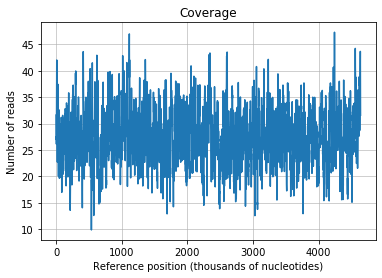

Среднее покрытие: 27.5
Доля покрытой области генома 100.0%


In [32]:
coverage(sam, ref_len)

## 2. Частоты различных замен

In [33]:
errors(sam, ref)

,A,T,C,G,_
A,0.968653,0.003508,0.004461,0.010409,0.012969
_,0.254879,0.254365,0.243645,0.247111,0.000000
C,0.003539,0.011679,0.970061,0.002862,0.011859
G,0.011564,0.003497,0.002668,0.969884,0.012386
T,0.003431,0.968517,0.011092,0.004118,0.012841



Средний процент ошибок в ридах 7.7203%

Статистика длин инделов
Среднее 1.9
Среднеквадратичное отклонение 3.7
Минимум 1, максимум 1196
Интервал, в который попадает 95% [-5.6, 9.3]

Статистика качества (замена)
Среднее 8.3
Среднеквадратичное отклонение 4.8
Минимум 1, максимум 93
Интервал, в который попадает 95% [-1.4, 18.0]

Статистика качества (вставка)
Среднее 11.0
Среднеквадратичное отклонение 7.1
Минимум 1, максимум 93
Интервал, в который попадает 95% [-3.2, 25.3]

Процент инделов, находящихся рядом с гомополимерными участками 1.5%


**Вывод:** У Оксфорд нанопор покрытие меньше, но меньше средний процент ошибок. У ПакБио чаще ошибки в виде вставки/удаления.